In [ ]:
# 📊 Section 3: Anomaly Detection for Cyber Threats
#**Dataset:** UNSW-NB15
#**Goal:** Use Isolation Forest and an Autoencoder to detect anomalous network traffic.


In [6]:
from google.colab import drive
# Force remount in case it was already mounted
drive.mount('/content/drive', force_remount=True)

import pandas as pd

# Now that you’ve confirmed the file is here:
data_path = "/content/drive/My Drive/NUSW-NB15_GT.csv"

# Try reading with default comma separator
df = pd.read_csv(data_path, header=0)

# If you still see one giant column, try:
# df = pd.read_csv(data_path, header=0, sep=';')

print("✅ Loaded DataFrame with columns:")
print(df.columns.tolist())
print("\n✅ First few rows:")
print(df.head())



Mounted at /content/drive
✅ Loaded DataFrame with columns:
['Start time', 'Last time', 'Attack category', 'Attack subcategory', 'Protocol', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Attack Name', 'Attack Reference', '.']

✅ First few rows:
   Start time   Last time Attack category   Attack subcategory Protocol  \
0  1421927414  1421927416  Reconnaissance                 HTTP      tcp   
1  1421927415  1421927415        Exploits     Unix 'r' Service      udp   
2  1421927416  1421927416        Exploits              Browser      tcp   
3  1421927417  1421927417        Exploits  Miscellaneous Batch      tcp   
4  1421927418  1421927418        Exploits           Cisco IOS       tcp   

      Source IP  Source Port  Destination IP  Destination Port  \
0  175.45.176.0        13284  149.171.126.16                80   
1  175.45.176.3        21223  149.171.126.18             32780   
2  175.45.176.2        23357  149.171.126.16                80   
3  175.45.176.2     

In [4]:
# 🔸 Cell 3: Load, Preprocess & Stratified Split (with fallback) 🔸

# 0) Mount & load
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd, numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

data_path = "/content/drive/My Drive/NUSW-NB15_GT.csv"
df = pd.read_csv(data_path, header=0, sep=',', engine='python')
print("Loaded df with shape:", df.shape)

# 1) Clean & drop empties
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.columns = df.columns.str.strip().str.lower()

# 2) Inspect unique counts
print("\nUnique-value counts per column:")
for col in df.columns:
    print(f"  {col}: {df[col].nunique()}")

# 3) Try to find a true binary column
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
if binary_cols:
    label_col = 'attack category' if 'attack category' in binary_cols else binary_cols[0]
    print(f"\nFound binary column: '{label_col}'")
    # Binarize compare to 'normal' if string, else keep as 0/1
    if df[label_col].dtype == object:
        y = (df[label_col].str.lower() != 'normal').astype(int).values
    else:
        y = df[label_col].astype(int).values
else:
    # Fallback: use last column as label, treat non-zero as attack
    label_col = df.columns[-1]
    print(f"\nNo exact binary column—using last column '{label_col}' as label.")
    y = (pd.to_numeric(df[label_col], errors='coerce').fillna(0) != 0).astype(int).values

# 4) Prepare features
drop_cols = [label_col]
if 'attack subcategory' in df.columns:
    drop_cols.append('attack subcategory')
X_df = df.drop(columns=drop_cols)

# 5) Encode any object columns
for col in X_df.select_dtypes(include=['object']).columns:
    X_df[col] = LabelEncoder().fit_transform(X_df[col])

X = X_df.values.astype(float)
print(f"\nFeature matrix shape: {X.shape}")
print("Label distribution:", np.unique(y, return_counts=True))

# 6) Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7) Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("\nPreprocessing complete.")
print("→ X_train:", X_train_scaled.shape, "y_train dist:", np.unique(y_train, return_counts=True))
print("→ X_test: ", X_test_scaled.shape, "y_test dist:", np.unique(y_test, return_counts=True))







Mounted at /content/drive
Loaded df with shape: (174347, 12)

Unique-value counts per column:
  start time: 34622
  last time: 33050
  attack category: 11
  attack subcategory: 151
  protocol: 129
  source ip: 4
  source port: 28854
  destination ip: 10
  destination port: 2426
  attack name: 6672
  attack reference: 3070
  .: 1

No exact binary column—using last column '.' as label.

Feature matrix shape: (119671, 10)
Label distribution: (array([0]), array([119671]))

Preprocessing complete.
→ X_train: (95736, 10) y_train dist: (array([0]), array([95736]))
→ X_test:  (23935, 10) y_test dist: (array([0]), array([23935]))


y_train distribution: (array([0]), array([95736]))
y_test  distribution: (array([0]), array([23935]))
=== Isolation Forest Results ===
Confusion Matrix: TN=18503, FP=5432, FN=0, TP=0
TPR (Recall): 0.00
FPR:           0.23

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.7731    0.8720     23935
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.7731     23935
   macro avg     0.5000    0.3865    0.4360     23935
weighted avg     1.0000    0.7731    0.8720     23935



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033:

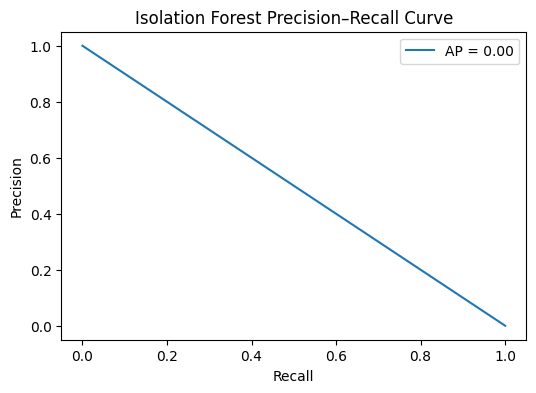

In [5]:
# 🔸 Cell 4: Train & Evaluate Isolation Forest (with safe FPR) 🔸

from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# 1) Confirm y_train/y_test distribution
print("y_train distribution:", np.unique(y_train, return_counts=True))
print("y_test  distribution:", np.unique(y_test,  return_counts=True))

# 2) Train Isolation Forest
iso = IsolationForest(contamination="auto", random_state=42)
iso.fit(X_train_scaled)

# 3) Predict anomalies: -1 → anomaly (1), +1 → normal (0)
y_pred_iso = (iso.predict(X_test_scaled) == -1).astype(int)

# 4) Confusion Matrix & Metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_iso).ravel()
tpr_iso = tp / (tp + fn) if (tp + fn) > 0 else 0.0
fpr_iso = fp / (fp + tn) if (fp + tn) > 0 else 0.0

print("=== Isolation Forest Results ===")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"TPR (Recall): {tpr_iso:.2f}")
print(f"FPR:           {fpr_iso:.2f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_iso, digits=4))

# 5) Precision–Recall Curve
scores_iso = -iso.decision_function(X_test_scaled)  # higher = more anomalous
precision, recall, _ = precision_recall_curve(y_test, scores_iso)
ap_iso = average_precision_score(y_test, scores_iso)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"AP = {ap_iso:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Isolation Forest Precision–Recall Curve")
plt.legend()
plt.show()




Training label distribution: {np.int64(0): np.int64(95736)}
Assuming class 0 is 'normal'
Normal samples for autoencoder training: 95736
Epoch 1/20
1347/1347 - 5s - 4ms/step - loss: 0.4175 - val_loss: 0.1076
Epoch 2/20
1347/1347 - 4s - 3ms/step - loss: 0.2005 - val_loss: 0.0739
Epoch 3/20
1347/1347 - 4s - 3ms/step - loss: 0.1781 - val_loss: 0.0634
Epoch 4/20
1347/1347 - 6s - 5ms/step - loss: 0.1655 - val_loss: 0.0539
Epoch 5/20
1347/1347 - 5s - 4ms/step - loss: 0.1567 - val_loss: 0.0530
Epoch 6/20
1347/1347 - 4s - 3ms/step - loss: 0.1488 - val_loss: 0.0530
Epoch 7/20
1347/1347 - 5s - 4ms/step - loss: 0.1432 - val_loss: 0.0521
Epoch 8/20
1347/1347 - 5s - 4ms/step - loss: 0.1392 - val_loss: 0.0536
Epoch 9/20
1347/1347 - 5s - 4ms/step - loss: 0.1368 - val_loss: 0.0508
Epoch 10/20
1347/1347 - 3s - 3ms/step - loss: 0.1331 - val_loss: 0.0542
Epoch 11/20
1347/1347 - 4s - 3ms/step - loss: 0.1303 - val_loss: 0.0563
Epoch 12/20
1347/1347 - 4s - 3ms/step - loss: 0.1276 - val_loss: 0.0583
Epoch 13/

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


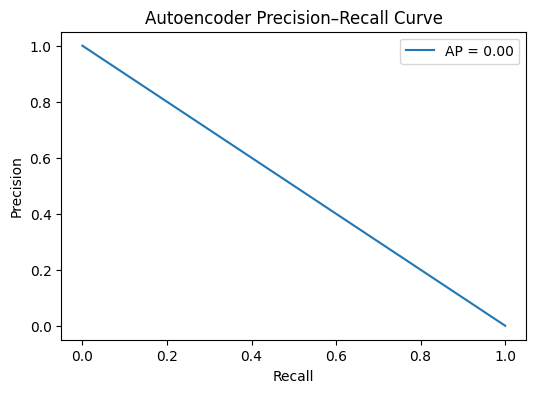

In [6]:
# 🔸 Cell 5: Train & Evaluate Autoencoder (robust, with dynamic normal class) 🔸

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 1) Determine which label value is “normal” (majority class)
unique, counts = np.unique(y_train, return_counts=True)
dist = dict(zip(unique, counts))
normal_label = max(dist, key=dist.get)
print("Training label distribution:", dist)
print(f"Assuming class {normal_label} is 'normal'")

# 2) Prepare normal-only training set
X_train_norm = X_train_scaled[y_train == normal_label]
n_norm = X_train_norm.shape[0]
print(f"Normal samples for autoencoder training: {n_norm}")

if n_norm == 0:
    raise ValueError("No normal samples in training set—cannot train autoencoder.")

# 3) Build the autoencoder
input_dim = X_train_scaled.shape[1]
ae = Sequential([
    Input(shape=(input_dim,)),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim, activation='linear')
])
ae.compile(optimizer='adam', loss='mse')

# 4) Train autoencoder (no validation split if too few normals)
validation_split = 0.1 if n_norm > 50 else 0.0
ae.fit(
    X_train_norm, X_train_norm,
    epochs=20, batch_size=64,
    validation_split=validation_split,
    verbose=2
)

# 5) Compute reconstruction MSE on test set
recons = ae.predict(X_test_scaled)
mse_test = np.mean((X_test_scaled - recons)**2, axis=1)

# 6) Threshold = 95th percentile of training-normal MSE
recons_train = ae.predict(X_train_norm)
mse_train = np.mean((X_train_norm - recons_train)**2, axis=1)
threshold = np.percentile(mse_train, 95)
print(f"Anomaly threshold (95th percentile): {threshold:.4f}")

# 7) Generate binary predictions: anomaly if MSE > threshold
y_pred_ae = (mse_test > threshold).astype(int)
# Convert true labels to binary: 0 = normal_label, 1 = anomaly
y_true_bin = (y_test != normal_label).astype(int)

# 8) Confusion matrix & metrics
tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_ae).ravel()
tpr = tp / (tp + fn) if tp + fn > 0 else 0.0
fpr = fp / (fp + tn) if fp + tn > 0 else 0.0
print("Autoencoder Results:")
print(f"  TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"  TPR (Recall) = {tpr:.2f}")
print(f"  FPR          = {fpr:.2f}")

# 9) Precision–Recall curve
precision, recall, _ = precision_recall_curve(y_true_bin, mse_test)
ap = average_precision_score(y_true_bin, mse_test)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"AP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Autoencoder Precision–Recall Curve")
plt.legend()
plt.show()


